# Zakelijk inzicht
Hier lees je het doel van deze notebook en welke waarde het oplevert voor de opdrachtgever

## Doel
Het doel van dit notebook is om een voorspelling te kunnen maken van het gemiddelde van de CV-waardes over verloop van tijd.

## Situatie
Om deze regressie te maken bezitten we over een dataset met waarden per jaar per methode. Per jaar per producent is ook mogelijk.

De data bestaat uit CAP (Amerikaanse) en EurA1c (Europese) data. Deze data moet gescheiden worden geinterpreteerd.

# Data inzicht
Hier lees je inzicht van het data bestand en de data waar in dit notebook mee wordt gewerkt.

## Verzamelen van de data
Het verzamelen van de data komt oorspronkelijk voor door de CAP en EurA1c rapporten om te zetten van PDF bestanden naar één Excel-bestand.

In [190]:
import pandas as pd
import seaborn as sns

df = df = pd.read_excel("Complete-dataset-FINAL.xlsx")
df['Year'] = pd.to_datetime(df["Year"], format='%Y')

cap = df.loc[df['Source (CAP/EurA1c)'] == 'CAP']
eur = df.loc[df['Source (CAP/EurA1c)'] == 'EURA1c']

Na het verzamelen van de data beschikken we over twee datasets. Die van de CAP data en de EurA1c data. Het "df" object bevat beide en gebruiken we om een algemene omschrijving te geven van de data. De reden van twee losse datasets zie je hieronder, de CV-waardes verschillen flink per dataset, vandaar dat ze los gebruikt worden.

Text(0.5, 1.0, 'CV waardes per jaar per bron')

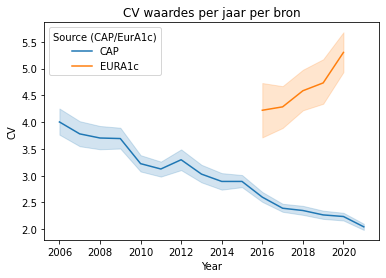

In [191]:
sns.lineplot(x="Year", y="CV", data=df, hue="Source (CAP/EurA1c)")
plt.title("CV waardes per jaar per bron")

## Data omschrijving
Hier lees je de omschrijving van de "df" dataset. Een kort overzicht met ruwe cijfers/feiten van de data.

In [192]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4684 entries, 0 to 4683
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Method name          4684 non-null   object        
 1   N (no. labs)         4684 non-null   object        
 2   Mean                 4602 non-null   float64       
 3   Bias                 4058 non-null   float64       
 4   CV                   4584 non-null   float64       
 5   Sample               4684 non-null   object        
 6   Reference Value      4656 non-null   float64       
 7   Year                 4684 non-null   datetime64[ns]
 8   Source (CAP/EurA1c)  4684 non-null   object        
 9   Type (Fresh/frozen)  4684 non-null   object        
 10  Manufacturer         4684 non-null   object        
 11  Total Error          4684 non-null   float64       
dtypes: datetime64[ns](1), float64(5), object(6)
memory usage: 439.2+ KB


Bovenstaand alle kolommen met onder andere het type data die de kolom bevat.

De CV waarde is een float, oftewel een decimaal kommagetal. En het jaar is een datum.

Je kunt ook zien dat er 4684 records zijn.

## Data exploratie


<AxesSubplot:title={'center':'CV-waarde van leveranciers over verloop van tijd'}, xlabel='Year', ylabel='CV'>

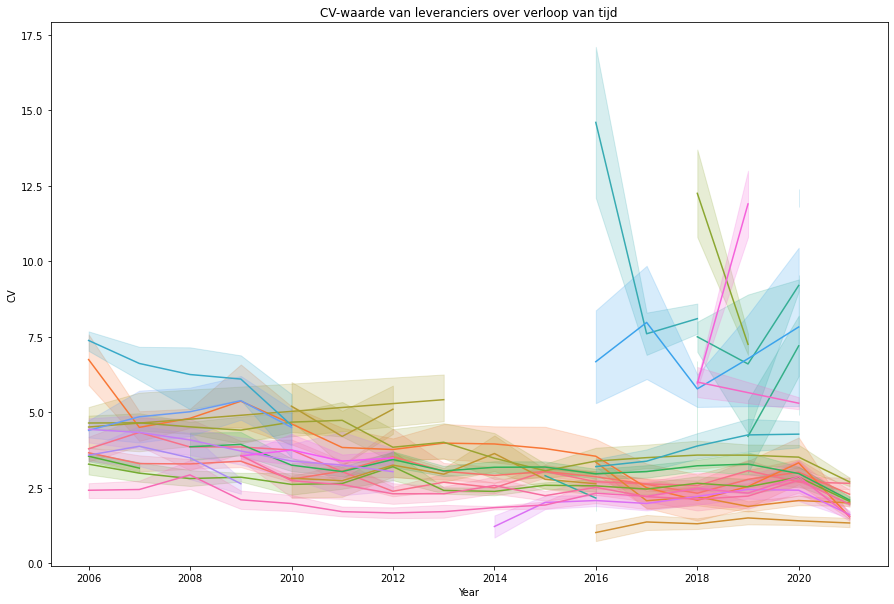

In [193]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
plt.title("CV-waarde van leveranciers over verloop van tijd")
sns.lineplot(data=df, x="Year", y="CV", hue="Manufacturer", legend=False)

Gesorteerd per leverancier kan je zien dat de data vrij incompleet is. Sommige leveranciers zijn maar enkele jaren onderdeel van de dataset.

Een belangrijk punt is dat de data punten per jaar geregistreert zijn. Dit houdt in dat we met de regressie met gemiddelden per jaar moeten gaan werken. Dit zal ervoor zorgen dat we bij de CAP data zo'n 15 datapunten zullen hebben. En voor de EurA1c zo'n 5 datapunten zullen hebben.

Voor een goed voorspellend model heb je meer datapunten nodig, dit zal er dus waarschijnlijk voor zorgen dat het regressiemodel zeer onbetrouwbaar is.

# Data voorbereiding
## Selecteren van data
De data die we nodig hebben om de vraag te beantwoorden is een split tussen de Europese en Amerikaanse data. Deze hebben we aan het begin van dit document gemaakt.

Verder hebben we de jaren nodig, gezien we op basis van tijd willen voorspellen.

De CV waarde hebben we nodig gezien we daar naar kijken.

In [194]:
cap = cap[["CV", "Year"]]
eur = eur[["CV", "Year"]]

## Data opschonen

In [195]:
print("Aantal Amerikaanse records pre dropna: " + str(len(cap)))
print("Aantal Europese records pre dropna: " + str(len(eur)))

cap.dropna(inplace=True)
eur.dropna(inplace=True)

print("Aantal Amerikaanse records post dropna: " + str(len(cap)))
print("Aantal Europese records post dropna: " + str(len(eur)))

Aantal Amerikaanse records pre dropna: 4170
Aantal Europese records pre dropna: 514
Aantal Amerikaanse records post dropna: 4070
Aantal Europese records post dropna: 514


Zo te zien worden er bij de Amerikaanse data 100 records uit gegooid met een dropna commando. Die is ervoor om regels met een NaN-waarde te verwijderen.

In [196]:
cap_year = cap.groupby(["Year"]).mean()
cap_year

,CV
Year,
2006-01-01,4.004167
2007-01-01,3.781301
2008-01-01,3.704065
2009-01-01,3.693827
2010-01-01,3.224859
2011-01-01,3.125000
2012-01-01,3.297740
2013-01-01,3.029560
2014-01-01,2.892453


In [197]:
eur_year = eur.groupby(["Year"]).mean()
eur_year

,CV
Year,
2016-01-01,4.222500
2017-01-01,4.286250
2018-01-01,4.587255
2019-01-01,4.733636
2020-01-01,5.303521


# Modellering
De techniek die we gaan gebruiken voor modellering is het ARIMA model. Om een ARIMA model te kunnen maken moeten we eerst een aantal waarden bepalen. (p, d, q)


## CAP

#### D waarde bepalen

In [198]:
from statsmodels.tsa.stattools import adfuller

df = cap_year

result = adfuller(df.CV.dropna())
print("p-value no differencing: ", str(result[1]))


result = adfuller(df.CV.diff().dropna())
print("p-value 1x differencing: ", str(result[1]))

result = adfuller(df.CV.diff().diff().dropna())
print("p-value 2x differencing: ", str(result[1]))

result = adfuller(df.CV.diff().diff().diff().dropna())
print("p-value 3x differencing: ", str(result[1]))

result = adfuller(df.CV.diff().diff().diff().diff().dropna())
print("p-value 4x differencing: ", str(result[1]))

result = adfuller(df.CV.diff().diff().diff().diff().diff().dropna())
print("p-value 5x differencing: ", str(result[1]))

d = 1

p-value no differencing:  0.9904716884527985
p-value 1x differencing:  6.307156120658524e-12
p-value 2x differencing:  0.0004352996241847752
p-value 3x differencing:  1.918469350172667e-19
p-value 4x differencing:  0.5875101017130218
p-value 5x differencing:  0.0


Zodra de P-value onder 0.05 duikt is dat de differencing die we aan moeten houden. In dit geval gebeurd dat bij 1x differencing

De "d" waarde = 1

#### P en Q waarden

/Users/sebastiaankolmschate/Library/Python/3.8/lib/python/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


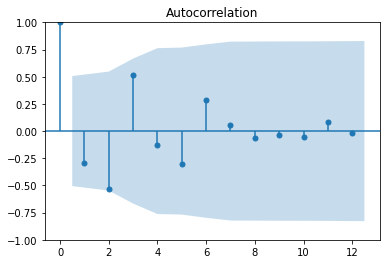

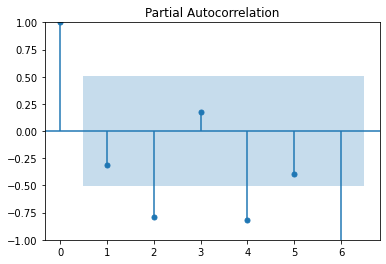

In [199]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import matplotlib.pyplot as plt

acf_fig = plot_acf(df.CV.diff().dropna())
pacf_fig = plot_pacf(df.CV.diff().dropna(), lags=6)
plt.show()

In [200]:
p = 1
q = 1

#### Het ARIMA model

/Users/sebastiaankolmschate/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/sebastiaankolmschate/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/sebastiaankolmschate/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/sebastiaankolmschate/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


<AxesSubplot:title={'center':'CAP CV-waarde over verloop van tijd'}, xlabel='Year'>

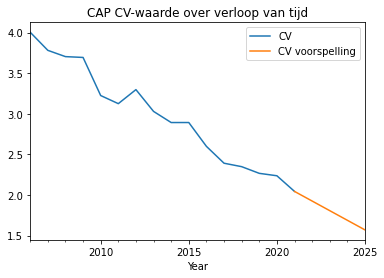

In [201]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(df, order=(p, d, q))
model_fit = model.fit()

forecast = model_fit.forecast(steps=4)
forecast_df = pd.DataFrame(forecast)
forecast_df.reset_index(inplace=True)
forecast_df.columns = ["Year", "CV voorspelling"]
forecast_df


forecast_series = forecast_df.groupby("Year").mean()

combined = pd.concat([df, forecast_series], axis=1)
combined
combined.loc['2021-01-01']["CV voorspelling"] = combined.loc['2021-01-01']["CV"]
combined.plot(title="CAP CV-waarde over verloop van tijd")

## EurA1c

In [202]:
from statsmodels.tsa.stattools import adfuller

df = eur_year

result = adfuller(df.CV.dropna())
print("p-value no differencing: ", str(result[1]))

result = adfuller(df.CV.diff().dropna())
print("p-value 1x differencing: ", str(result[1]))

result = adfuller(df.CV.diff().diff().dropna())
print("p-value 2x differencing: ", str(result[1]))

result = adfuller(df.CV.diff().diff().diff().dropna())
print("p-value 3x differencing: ", str(result[1]))

result = adfuller(df.CV.diff().diff().diff().diff().dropna())
print("p-value 4x differencing: ", str(result[1]))

result = adfuller(df.CV.diff().diff().diff().diff().diff().dropna())
print("p-value 5x differencing: ", str(result[1]))

d = 1

p-value no differencing:  0.9966007670352908
p-value 1x differencing:  0.6476985711765333


ValueError: sample size is too short to use selected regression component

Zodra de P-value onder 0.05 duikt is dat de differencing die we aan moeten houden. In dit geval gebeurd dat bij geen een, gezien we onze sample grootte te klein is krijgen we zelfs een error waardoor we niet door kunnen rekenen.

Om het simpel te houden houden we 1 aan. Gezien de differencing daar nog werkt.
De "d" waarde = 1

#### P en Q waarden

/Users/sebastiaankolmschate/Library/Python/3.8/lib/python/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


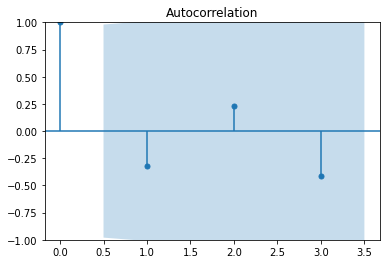

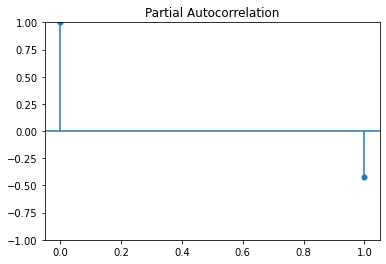

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import matplotlib.pyplot as plt

acf_fig = plot_acf(df.CV.diff().dropna())
pacf_fig = plot_pacf(df.CV.diff().dropna(), lags=1)
# plt.show()

Bij de autocorrelatie zie je dat bij de eerste 

In [ ]:
p = 1
q = 1

#### Het ARIMA model

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(df, order=(p, d, q))
model_fit = model.fit()

model_fit.summary()

/Users/sebastiaankolmschate/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/sebastiaankolmschate/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/sebastiaankolmschate/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/sebastiaankolmschate/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Us

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                     CV   No. Observations:                    5
Model:                 ARIMA(1, 1, 1)   Log Likelihood                  -0.513
Date:                Fri, 03 Jun 2022   AIC                              7.027
Time:                        13:11:57   BIC                              5.186
Sample:                    01-01-2016   HQIC                             2.987
                         - 01-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9072     10.890      0.083      0.934     -20.437      22.251
ma.L1         -0.5241     29.230     -0.018      0.986     -57.814      56.766
sigma2         0.0626      0.459      0.136      0.892      -0.838       0.963
===================================================================================
Ljung-Box (L1) (Q):                   2.55   Jarque-Bera (JB):                 0.44
Prob(Q):                              0.11   Prob(JB):                         0.80
Heteroskedasticity (H):                nan   Skew:                             0.37
Prob(H) (two-sided):                   nan   Kurtosis:                         1.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:title={'center':'EurA1c CV-waarde over verloop van tijd'}, xlabel='Year'>

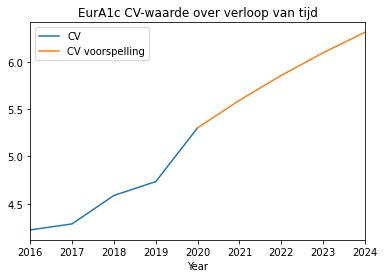

In [ ]:
forecast = model_fit.forecast(steps=4)
forecast_df = pd.DataFrame(forecast)
forecast_df.reset_index(inplace=True)
forecast_df.columns = ["Year", "CV voorspelling"]
forecast_df

forecast_series = forecast_df.groupby("Year").mean()

combined = pd.concat([df, forecast_series], axis=1)
combined
combined.loc['2020-01-01']["CV voorspelling"] = combined.loc['2020-01-01']["CV"]
combined.plot(title="EurA1c CV-waarde over verloop van tijd")

# Evaluatie
Beide tabellen zijn vanwege een te lage betrouwbaarheid beide niet bruikbaar. Ze hebben beide een P>z waarde rond de 1. Dat geeft aan dat het zeer onbetrouwbaar is.


## EurA1c
De trend van EurA1c is dat de CV-waarden zullen blijven stijgen. Het ARIMA model geeft eenzelfde lijn.

Vanwege de lage sample waarde was het echter lastig om zowel de P en Q waarde als de D waarde te bepalen. Ook kijkend naar de P > z waarde is het model erg onbetrouwbaar en niet bruikbaar.

## CAP
Kijkend naar de grafiek van CAP is te zien dat het te verwachten is dat de CV-waarde blijft dalen.

Ter discussie staat het bepalen van de P en Q waarden. Vanwege de lage sample grootte is het lastig deze correct vast te stellen, hierbij zijn dus ook aannames gemaakt om daar 1 voor te gebruiken.